Implementation of the points generation procedure copied from Nicolas Rougier here:

https://github.com/rougier/recursive-voronoi

and originally by Johannes Dollinger, see https://github.com/emulbreh/bridson

The algorithm is described in this exerpt from the original paper:

The algorithm takes as input the extent of the sample domain in $R^n$, the minimum distancer between samples, and a constant `k`  as the limit of samples to choose before rejection in the algorithm (typically `k` = 30).

### Step 0.
Initialize an $n$-dimensional background grid for storing samples and accelerating spatial searches.

We pick the cell size to be bounded by $r/\sqrt{n}$, so that each grid cell will contain at most one sample, and thus the grid can be implemented as a simple $n$-dimensional array of integers: the default -1 indicates no sample, a non-negative integer gives the index of the sample located in a cell. 

### Step 1.

Select the initial sample, $x_0$, randomly chosen uniformly from the domain. Insert it into the background grid, and initialize the “active list” (an array of sample indices) with this index (zero).

### Step 2.

While the active list is not empty, choose a random index from it (say $i$). Generate up to `k` points chosen uniformly from the spherical annulus between radius $r$ and $2r$ around $x_i$. For each point in turn, check if it is within distance $r$ of existing samples (using the background grid to only test nearby samples). If a point is adequately far from existing samples, emit it as the next sample and add it to the active list. If after `k` attempts no such point is found, instead remove $i$ from the active list.


In [5]:
import numpy as np
from math import tau, cos, sin, sqrt, ceil, floor
import matplotlib.pyplot as plt

In [40]:
a = [1, 2, 3]

np.random.shuffle(a)
a

[2, 1, 3]

In [41]:
type(a)

list

In [48]:
point

array([2.97576716, 0.05799503])

In [53]:
np.ceil(point/grid_step).astype(int).clip(
    [0, 0], np.array(grid_shape)-1)

array([21,  1])

In [59]:
np.mod(np.array([-2, 48]),  np.array(grid_shape)-1)

array([19,  5])

In [60]:
grid_shape

(22, 44)

In [187]:
def blue_noise(width, height, radius, k=30, seed=None):    
    """
    Generate blue noise over a two-dimensional rectangle of size (width, height)
    Parameters
    ----------
    width, height : floats
        Two-dimensional domain (width x height) 
    radius : float
        Minimum distance between samples
    k : int, optional
        Limit of samples to choose before rejection (typically k = 30)
    seed : int, optional
        If provided, this will set the random seed before generating noise,
        for valid pseudo-random comparisons.
    References
    ----------
    .. [1] Fast Poisson Disk Sampling in Arbitrary Dimensions, Robert Bridson,
           Siggraph, 2007. :DOI:`10.1145/1278780.1278807`
    Implementation by Johannes Dollinger,
    see https://github.com/emulbreh/bridson

    """
    # When given a seed, we use a private random generator in order to not
    # disturb the default global random generator
    if seed is not None:
        from numpy.random.mtrand import RandomState
        rng = RandomState(seed=seed)
    else:
        rng = np.random


    grid_step = radius / sqrt(2)

    grid_shape = ceil(width/grid_step), ceil(height/grid_step)
    N, M = grid_shape
    
    
    grid = -np.ones(grid_shape, dtype=int)
    points = []
    actives = []
    p0 = rng.random(size=2) * np.array([width, height])
    points.append(p0)
    actives.append(p0)
    i, j = np.floor(p0/grid_step).astype(int)
    
    grid[i, j] = 0
    n = 0

    while actives:

        rng.shuffle(actives)
        point = actives[-1]

        rhos = rng.uniform(radius, 2*radius, size=k)
        thetas = rng.uniform(0, tau, size=k)
        new_points = np.vstack([rhos * np.cos(thetas),
                                rhos * np.sin(thetas)]) + point[:, None]
        #new_points = new_points.clip(min=0, max=np.array([width, height])[:, None]) 
        for p in new_points.T:
            i, j = np.floor(p/grid_step).astype(int)
            if not ((0 <= i < N) and (0 <= j < M)):
                continue
            local = (
                slice(max(i-1, 0), min(i+1, N)),
                slice(max(j-1, 0), min(j+1, M))
            )
            if not np.all(grid[local].shape):
                continue
            if grid[local].max() < 0:
                n += 1
                grid[i, j] = n
                actives.append(p)
                points.append(p)
                break
        else:
            actives.pop()
    return np.array(points)

In [188]:
print(radius)

0.6472086375185664


In [189]:
%pdb

Automatic pdb calling has been turned ON


In [198]:
k = 30

width, height = tau/2, tau

num_points = 300
area = 2 * tau

radius = np.sqrt(area / num_points)

points = blue_noise(width, height, radius)


In [196]:
points.shape


(4203, 2)

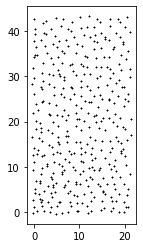

In [199]:


fig, ax = plt.subplots()
ax.plot(np.array(points)[:, 0]/grid_step-0.5, np.array(points)[:, 1]/grid_step-0.5, 'k+', ms=2)
ax.set_aspect('equal')

In [200]:
from scipy.spatial import distance

In [201]:
pair_dists = distance.pdist(points)

In [202]:
pair_dists.mean()

2.601000518874657

In [203]:
pair_dists.min()

0.016734270570912726

In [205]:
radius

0.2046653415892977

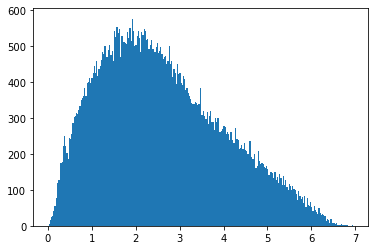

In [204]:
_ = plt.hist(pair_dists, bins=256)

In [103]:
radius

0.2046653415892977

In [106]:
points.shape

(220, 2)

TypeError: list indices must be integers or slices, not tuple

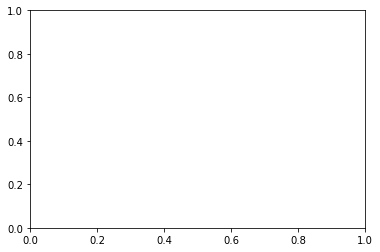

In [86]:
fig, ax = plt.subplots()


ax.scatter(points[:, 0], points[:, 1])
ax.set_aspect("equal")

In [108]:
from tyssue.generation.shapes import sheet_from_cell_centers

In [109]:

x = np.cos(points[:, 0]) * np.cos(points[:, 1])
y = np.sin(points[:, 0]) * np.cos(points[:, 1])
z = np.sin(points[:, 1])

In [110]:
points_ = np.vstack([x, y, z]).T

In [111]:
import ipyvolume as ipv
ipv.clear()
ipv.scatter(x, y, z)
ipv.squarelim()
ipv.show()

In [70]:
sheet = sheet_from_cell_centers(points_)

In [77]:
from tyssue.draw import sheet_view
ipv.clear()
fig, mesh = sheet_view(sheet, mode="3D")
fig

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [75]:
from tyssue import ClosedSheetGeometry as sgeom

from tyssue import ClosedMonolayerGeometry as geom
from tyssue.solvers import QSSolver
from tyssue.generation import extrude


from tyssue.dynamics import effectors, model_factory



In [76]:
sgeom.update_all(sheet)

In [78]:
sheet.face_df.area.mean()

0.0551682108035031

In [80]:
for i in range(10):
    sgeom.scale(sheet, sheet.face_df.area.mean()**-0.5, coords=list('xyz'))
    sgeom.update_all(sheet)

print(sheet.face_df.area.mean())


1.0000000000000004


In [86]:
smodel = model_factory(
    [
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
        effectors.LineTension
    ]
)

specs = {
    "face" : {
        "area_elasticity": 1.0,
        "prefered_area": 1.0,
    },
    "edge" : {
        "line_tension": 1e-3
    },
    "settings": {
        "lumen_prefered_vol" : sheet.settings['lumen_vol'],
        "lumen_vol_elasticity" : 1e-4,
    }
}

sheet.update_specs(specs, reset=True)


Reseting column area_elasticity of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column line_tension of the edge dataset with new specs


In [87]:
solver = QSSolver()


In [89]:

res = solver.find_energy_min(sheet, sgeom, smodel)

In [90]:
from tyssue.draw import sheet_view
ipv.clear()
fig, mesh = sheet_view(sheet, mode="3D")
fig

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…